In [1]:
##Code to read interpolated simulated long light curve (already in sec) and create power spectrum

"""
LCgenerationDE.py

Created on Sep 27 16:18:50 2021

Original Author: Ryne Dingler


requires:
    os, sys, numpy, pandas, scipy, matplotlib, astropy, time

"""

import os
import sys
import pandas as pd
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit
from scipy import stats
import scipy.special as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import gridspec
from astropy.io import fits
from astropy.table import Table
import time

In [2]:
## This section contains the equations used for fits to data

def linear(x,m,b):
    return m*x+b 

def piecewise_linear(x,x_turn,m1,m2,b1,b2):
    return np.piecewise(x,[x<x_turn,x>x_turn],[lambda x:m1*x+b1, lambda x:m2*x+b2])

def lorentz(x,cen,gamma):
    return (0.5*gamma/np.pi)/((x-cen)**2 + (0.5*gamma)**2)

def combolorentz(x,cen,gamma,m,b):
    return linear(x,m,b)+lorentz(x,cen,gamma)

def linearknee(x,x_knee,m,b):
    ## frequency must not be lograithmic, logarithmic operation occurs in fit;
    ## knee-bend method adapted from  Uttley et al. 2002
    return b+m/2*np.log10(1+(x/x_knee)**2)

def gaussian(x, A, μ, σ):
    return A * np.exp(-(x - μ)**2 / (2*σ**2))

def stdev(array,avg):
    return np.sqrt(np.mean(abs(np.subtract(array,avg))**2))

def chisquare_test(obs,exp,std):
    return np.sum((exp-obs)**2 / std**2)

def percentile(array,value,rank = False):
    part = 0
    tot = len(array)
    for i in array:
        if value > i:
            part += 1
    if rank == True:
        print("Rank: %i/%i"%(part,tot))
    return 100*part/tot

In [3]:
## This section contains functions for finding points within the PS data

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_intersection(m1,m2,b1,b2):
  
    xi = (b2-b1) / (m1-m2)

    return xi

def find_yintercept(m,xarr,yarr):
    b_arr = []
    for i in range(0,len(xarr)):
        b_arr.append(yarr[i] - m*xarr[i])
    b = np.mean(b_arr)
    return b


def findnoise(binnedps,logstd,poisson):
    ## f at which noise dominates is estimated by creating a broken powerlaw fit 
    ## where the high-f portion flattens to a slope of zero and returning the turn frequency
    ## use all 500 ps for best accuracy
  
    print("Estimating noise frequency.\n")
   
    freq = np.log10(list(binnedps[0]))
    power = np.log10(list(binnedps[1]))
    
    psd = np.column_stack((freq,power,logstd))
    
    freq_above_noise = np.array([x for x,y,z in psd if y-z >= np.log10(poisson)])
#     pow_above_noise = np.array([x for x,y,z in psd if y-z >= poisson])
    
    try:
        meansub_pars, _ = curve_fit(f = piecewise_linear, xdata = freq, ydata = power, sigma = logstd, absolute_sigma = True,\
                                        p0 = (freq_above_noise[-1],-2., 0.0, 0.0, np.log10(poisson)), bounds = ((-4.8,-4.0,-0.0001,-np.inf,-np.inf),\
                                                                                                 (-3., 0.0, 0.0001,np.inf,np.inf)), maxfev=99999) 
    except:
        meansub_pars, _ = curve_fit(f = piecewise_linear, xdata = freq, ydata = power, sigma = logstd, absolute_sigma = True,\
                                    p0 = (-4.0,-2., 0.0, 0.0, np.log10(poisson)), bounds = ((-4.8,-4.0,-0.0001,-np.inf,-np.inf),\
                                                                                             (-3.6, 0.0, 0.0001,np.inf,np.inf)), maxfev=99999) 
    
    noisefreq = 10**meansub_pars[0]
    
    return(noisefreq)

In [4]:
###########################################################################################################
def Min_PDF(params,hist,model,force_scipy=True):
    '''
    PDF chi squared function allowing the fitting of a mixture distribution
    using a log normal distribution and a gamma distribution
    to a histogram of a data set.
    
    inputs:
        params (array)   - function variables - kappa, theta, lnmu,lnsig,weight
        hist (array)     - histogram of data set (using numpy.hist)
        force_scipy (bool,optional) - force the function to assume a scipy model
    outputs:
        chi (float) - chi squared
        
    Ref: Connolly 2015
    '''

    mids = (hist[1][:-1]+hist[1][1:])/2.0

    try:
        if model.__name__ == 'Mixture_Dist':
            model = model.Value
            m = model(mids,params)
        elif model.__module__ == 'scipy.stats.distributions' or \
            model.__module__ == 'scipy.stats._continuous_distns' or \
                force_scipy == True:
            m = model.pdf    
        else:    
            m = model(mids,*params)
    except AttributeError:
        m = model(mids,*params)
    
    chi = (hist[0] - m)**2.0
    
    return(np.sum(chi))

def OptBins(data, maxbinS=10, maxbinL=20, minbin = 7):
    '''
     Python version of the 'optBINS' algorithm by Knuth et al. (2006) - finds 
     the optimal number of bins for a one-dimensional data set using the 
     posterior probability for the number of bins. WARNING sometimes doesn't
     seem to produce a high enough number by some way...
    
     inputs:
         data (array)           - The data set to be binned
         maxM (int, optional)   - The maximum number of bins to consider
         
     outputs:
        Opt (int)           - The optimum number of bins
    
     Ref: Connolly 2015, K.H. Knuth. 2012. Optimal data-based binning for histograms
     and histogram-based probability density models, Entropy.
     Ref: Shimazaki 2007. Neural Comput 19 1503-1527, 2007
    '''
    def posterior_opt(binM,data):
        logp = []
        for M in binM:
            n = np.histogram(data,bins=M)[0] # Bin the data (equal width bins)

            # calculate posterior probability
            part1 = N * np.log(M) + sp.gammaln(M/2.)
            part2 = - M * sp.gammaln(0.5)  - sp.gammaln(N + M/2.)
            part3 = np.sum(sp.gammaln(n+0.5))
            logp.append(part1 + part2 + part3) # add to array of posteriors
        
        Opt = int(binM[np.argmax(logp)]+0.5)
        return(Opt)
    
    def shimizaki_opt(binM,data):
        C = []
        for M in binM:
            n, bins = np.histogram(data,bins=M) # Bin the data (equal width bins)
            width = bins[1] - bins[0]

            k = np.nanmean(n)
            v = np.nanstd(n)

            # calculate posterior probability
            numer = 2*k - v
            denom = width**2
            C.append(numer/denom) # add to array of posteriors
        
        Opt = int(binM[np.argmin(C)]+0.5)
        return(Opt)
    
       
    
    N = len(data)

    Sqrt = int(np.ceil(np.sqrt(N)))
    Sturge = int(np.ceil(np.log2(N)) + 1.5)
    Rice = int(np.ceil(2*N**(1./3.)))
    
    skew = st.skew(data)
    try:
        Doane = int(1.5+ np.log2(N) + np.log2(1. + np.abs(skew)/np.sqrt(6.*(N-2.)/((N+1.)*(N+3.)))))
    except:
        Doane = minbin
    
    std = np.nanstd(data)
    try:
        Scott = int(0.5 + (N**(1./3.)*(np.nanmax(data) - np.nanmin(data))/(3.5*std)))
    except:
        Scott = minbin
    
    iqr = np.quantile(data,0.75) - np.quantile(data,0.25)
    try:
        FD = int(0.5 + (N**(1./3.)*(np.nanmax(data) - np.nanmin(data)) / (2.*iqr)))
    except:
        FD = minbin
    
    minM = np.nanmin([Sqrt,Sturge,Rice,Doane,Scott,FD])
    if minM < minbin:
        minM = minbin
    maxM = np.nanmax([Sqrt,Sturge,Rice,Doane,Scott,FD])
    if maxM < minbin:
        maxM = minbin

    binM = range(minM,maxM+1)
          
    if N >= 150:  
        if minM != maxM:
            return(posterior_opt(binM,data)) #find bin number of maximum probability
        else:
            return(posterior_opt(range(minbin,maxbinL),data))
    else:
        if minM != maxM:
            return(shimizaki_opt(binM,data)) #find bin number of maximum probability
        else:
            return(shimizaki_opt(range(minbin,maxbinS),data))


In [5]:
def find_bkg(target, sectbysect = False, sect = 0, group = 0):
    
    '''
     Search TESS FITS files to determine the mean bkg flux from each
     observed sector and overall
    
     inputs:
        target (string)        - Name of desired object to analyze
         
         
     outputs:
         mean_bkg (float)      - Mean bkg flux of all observed sectors
                                     as read from TESS FITS file
    
     Ref:  Uttley et al. 2002 and Smith et al. 2018
    '''
    
    mean_bkg = []
    
    fits_dir = '/users/rdingler/AGNstudy/QSO_FITS/'+target+'/'
       
    
    if sectbysect == False:
        ext = '.fits'
        sectors = 0
        for files in os.listdir(fits_dir):
            if files.endswith(ext):
                sectors += 1
                with fits.open(fits_dir+files) as hdu:
                    asn_table = Table(hdu[1].data)
#                     print(len(asn_table["FLUX_BKG"]))
                mean_bkg.append(np.mean(asn_table["FLUX_BKG"]))
            else:
                continue
        mean_bkg_mean = np.mean(mean_bkg)
        print("Mean background flux from %i sectors: %.2f"%(sectors,mean_bkg_mean))
        
    else:
        for x in sect:
            ext = 'sector'+str(int(x))+'.fits'
            for files in os.listdir(fits_dir):
                if files.endswith(ext):
                    with fits.open(fits_dir+files) as hdu:
                        asn_table = Table(hdu[1].data)
                    mean_bkg.append(np.mean(asn_table["FLUX_BKG"]))
                else:
                    continue    
        mean_bkg_mean = np.mean(mean_bkg)
        print("Mean background flux from sectors %s: %.2f"%(group,mean_bkg_mean))
        
# #         if group == 0:
#             ext = 'sector'+str(sect)+'.fits'
#             for files in os.listdir(fits_dir):
#                 if files.endswith(ext):
#                     with fits.open(fits_dir+files) as hdu:
#                         asn_table = Table(hdu[1].data)
#                     mean_bkg.append(np.mean(asn_table["FLUX_BKG"]))
#                 else:
#                     continue    
#             mean_bkg_mean = np.mean(mean_bkg)
#             print("Mean background flux from sector %i: %.2f"%(sect,mean_bkg_mean))
            
#     if sect == 0:

#         sects = np.fromstring(input("Which sectors are included in group %i (as list with spaces): "%group), dtype=float, sep = ' ')
        
              
    return mean_bkg_mean

In [6]:
def correct_data(df, rootdir, target, num_lcs, redshift, bkg, gausserr, Q, sectbysect = False, group = 0):
    '''
     Redshift correction, flattening, and gap reproduction for all simulated light curves.
     This is followed by creation of Power spectra for each light curve by fourier methods 
     and normalized under the Van der Klis factor (). All new light curves and power 
     spectra are saved to .dat files.
    
     inputs:
         df (data frame)        - Set of 501 lightcurves (lcs) in which only the 1st column 
                                     is time, and 2nd column is real lc 
         rootdir (directory)    - The directory in which lcs are stored
         target (string)        - Name of desired object to analyze
         num_lcs (int)          - Number of lcs (default = 501)
         redshift (float)       - Redshift of AGN
         bkg (int)              - Most common background flux count of target from FITS file
         gausserr (boolean)     - Are lc errors gaussian for Poisson noise level
         Q (int)                - Model determination value
         sectbysect (boolean)   - sector by sector analysis or not (default is False)
         sect (int)             - current sector under analysis if sectbysect is True
         group (int)            - current group of n sectors under analysis if sectbysect is True
         
     outputs:
        corrected_data (data frame)  - 501 1ight curves that have been corrected and had gaps
                                        inserted to match real light curve in which only the 1st column 
                                         is time, and 2nd column is real lc 
        full_ps (data frame)         - 501 normalized power spectra in which only the 1st column 
                                         is frequency, and 2nd column is real psd 
        poisson_vdk (float)          - Expected level of Poisson Noise by VdK normalization
    
     Ref:  Uttley et al. 2002 and Smith et al. 2018
    '''
    
    print("Correcting data.\n")
  
    ## Sequence of finding gaps in data, linearly interpolating between gaps, and plotting of new figures.

    ## Set intial values from the light curve dataframe 
    ## Plotting values first then write to .dat
    
    ## Determine length of one light curve
#     print(sectbysect)
    
#     if sectbysect == True:
#         single_lc_length = len(df[0])
#     else:
    single_lc_length = np.where(df[0] == 1800.)[0][1] - np.where(df[0] == 1800.)[0][0]
    startcad = single_lc_length
    endcad = startcad+single_lc_length
    
    
    
    ## Initialize arrays for plotting using REAL lightcurve
    
    ## Flatten light curve by removing longest linear trend
    mean_flux = np.mean(df[1][0:startcad])
    linear_fit = np.polyfit(df[0][0:startcad],df[1][0:startcad],1)
    
    flattened_reallc = np.subtract(df[1][0:startcad],linear_fit[0]*df[0][0:startcad])
    new_mean = np.mean(flattened_reallc)
    
    ## Shift light curve back to original mean
    flattened_reallc = flattened_reallc + (mean_flux-new_mean)
    mean_flux = np.mean(flattened_reallc)
             
    ## Find mean subtracted flux
    meansubflux = np.subtract(flattened_reallc,mean_flux)
    
    full_time = list(np.divide(df[0][0:startcad],(1+redshift))) ## redshift correction on real lc
    sampspace = np.abs(full_time[1]-full_time[0])#df[0][1]-df[0][0]
    print("Sample spacing: %f\n"%sampspace)
    
    ## Show old and new light curve
    plt.figure(figsize = (16,4))
    plt.errorbar(df[0][0:startcad],df[1][0:startcad],yerr = df[2][0:startcad], alpha = 1.0, label = "OG Real LC")
    plt.errorbar(df[0][0:startcad],flattened_reallc,yerr = df[2][0:startcad], alpha = 0.8, label = "flat LC")
    plt.legend()
    if sectbysect == False:
        plt.title(target+": Flattened Light curve")
        plt.savefig(rootdir+'/'+target+'_flattened_lc.png')
    else:
# #         if group == 0:
        plt.title(target+": Flattened Light curve, sector(S) %s"%group)
        plt.savefig(rootdir+'/'+target+'_flattened_lc_sector'+group+'.png')
#         if sect == 0:
#             plt.title(target+": Flattened Light curve, group %i"%group)
#             plt.savefig(rootdir+'/'+target+'_flattened_lc_group'+str(group)+'.png')
    
        
    
    plt.show()
    plt.close()

#####################################################################################
## Fourier methods to extract PSD of real light curve
    fspace = np.fft.fftfreq(len(full_time), d=sampspace)
    
    
    full_flux = list(meansubflux)
    full_err = list(df[2][0:startcad])
    
    dft = np.real(np.fft.fft(meansubflux))  #calculate power spectrum...
    ps = np.abs(dft)**2 
    
    real_ps = np.column_stack((fspace,ps))
    pos_freq_lcreal = [i for i,j in real_ps if i>0]
    
    
    A_rms2 = (2*sampspace)/(mean_flux**2 * len(meansubflux)) ##VdK normalization (A1 Vaughn 2003)
#     A_leahy = (2*sampspace)/(mean_flux**2 * len(meansubflux)) ##Leahy normalization (Vaughn 2003)
    pos_pow_lcreal = [A_rms2*j for i,j in real_ps if i>0]
#     pos_pow_lcreal = [A_leahy*j for i,j in real_ps if i>0]
    
    if gausserr == True:
        poisson_vdk = (2.0*sampspace*np.mean(np.array(full_err)**2))/mean_flux**2 ##VdK Poisson noise for gaussian errors (A3 Vaughn 2003)
#         poisson_vdk = (2.0*1800*np.mean(np.array(full_err)**2))/mean_flux**2 ##VdK Poisson noise for gaussian errors (A3 Vaughn 2003)
    else:
        poisson_vdk = 2.0*(mean_flux+bkg)/(mean_flux**2) ##VdK Poisson noise for non-gaussian errors (A2 Vaughn 2003)
    
#     poisson_leahy = 2.0
    
    full_ps = np.column_stack((pos_freq_lcreal,pos_pow_lcreal))
    
#     print(pos_freq_real)
####################################################################################### 
    
## Masking of simulated light curves

    badmask = np.where(np.array(full_err) == 0)[0]
    
    
    for k in range(1,num_lcs):
    
        startcad = k*single_lc_length
        endcad = startcad+single_lc_length
        
        
        t_slice = np.array(df[0][startcad:endcad])
        
        lc_slice = np.array(df[1][startcad:endcad])
        
        err_slice = np.array(df[2][startcad:endcad])
        
        for i in badmask:
            lc_slice[i] = 0
            err_slice[i] = 0
        
        nozero_full = np.column_stack((t_slice,lc_slice))
        
        nozero_time = [i for i,j in list(nozero_full) if j != 0]
        nozero_flux = [j for i,j in list(nozero_full) if j != 0]
        
        good_lc_only = np.column_stack((nozero_time,nozero_flux))
       
        
        patch = np.zeros(2).reshape((1,2))
        
        timearray = np.array(nozero_time)
        fluxarray = np.array(nozero_flux)

        
        for i in badmask:                                          # Loop over each bad cadence...
            patchflux = np.interp(t_slice[i],timearray,fluxarray)  # Calculate interpolated value at the bad cadence value.
            newvals = [t_slice[i],patchflux]
            patchrow = np.column_stack(newvals)
        
            patch = np.concatenate([patch,patchrow])   
            
        patch = np.delete(patch, (0), axis=0)
        
        combine_patch = np.concatenate([good_lc_only,patch])               # Join the good array and the patch.
        combine_patch_sort = combine_patch[combine_patch[:,0].argsort()]

        patched_lc_time = combine_patch_sort[:,0]
        patched_lc_flux = combine_patch_sort[:,1]
        
        ## Flatten light curve by removing longest linear trend
        mean_flux = np.mean(patched_lc_flux)
        linear_fit = np.polyfit(patched_lc_time,patched_lc_flux,1)
        flattened_simlc = np.subtract(patched_lc_flux,linear_fit[0]*patched_lc_time)
        new_mean = np.mean(flattened_simlc)
        
        ## Shift light curve back to original mean
        flattened_simlc = flattened_simlc + (mean_flux-new_mean)
        mean_flux = np.mean(flattened_simlc)
        
        ## Find mean subtracted flux and redshift correct time
        zcorr_time = np.divide(patched_lc_time,(1+redshift))
        meansubflux = np.subtract(flattened_simlc,mean_flux)

        ##Combine corrected, simulated lcs with corrected, real lc
        full_time = np.concatenate((full_time,zcorr_time))
        full_flux = np.concatenate((full_flux,meansubflux))
        full_err = np.concatenate((full_err,err_slice))
        
        
        ##############################################################################

        ## PSD analysis
        ## Renormalization
        A_rms2_sim = (2*sampspace)/(mean_flux**2 * len(meansubflux)) ##VdK normalization (A1 Vaughn 2003)
#         A_rms2_sim = (2*sampspace)/(mean_flux**2 * len(meansubflux)) ##VdK normalization (A1 Vaughn 2003)
        
        dft = np.real(np.fft.fft(meansubflux))  #calculate power spectrum...
        ps = np.abs(dft)**2
        
        fspace = np.fft.fftfreq(zcorr_time.size, d=sampspace)        
        
        sim_ps = np.column_stack((fspace,ps))
        
        #######################################################################################
     
        
        pos_pow_lcsim = [A_rms2*j for i,j in sim_ps if i>0]
#         pos_pow_lcsim = [A_leahy*j for i,j in real_ps if i>0]
        
        full_ps = np.column_stack((full_ps,pos_pow_lcsim))
        
            
    if sectbysect == False:    
        if Q == 0: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_plaw.dat',full_ps,delimiter=' ')
        elif Q == 1: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_brkn.dat',full_ps,delimiter=' ')
        elif Q == 2: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_lrntz.dat',full_ps,delimiter=' ')
        elif Q == 3: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_bend.dat',full_ps,delimiter=' ')
            
    else:
#         if group == 0:
        if Q == 0: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_plaw_sector'+group+'.dat',full_ps,delimiter=' ')
        elif Q == 1: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_brkn_sector'+group+'.dat',full_ps,delimiter=' ')
        elif Q == 2: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_lrntz_sector'+group+'.dat',full_ps,delimiter=' ')
        elif Q == 3: 
            np.savetxt(rootdir+'/'+target+'_sim_500psarray_bend_sector'+group+'.dat',full_ps,delimiter=' ')
#         if sect == 0:
#             if Q == 0: 
#                 np.savetxt(rootdir+'/'+target+'_sim_500psarray_plaw_group'+str(group)+'.dat',full_ps,delimiter=' ')
#             elif Q == 1: 
#                 np.savetxt(rootdir+'/'+target+'_sim_500psarray_brkn_group'+str(group)+'.dat',full_ps,delimiter=' ')
#             elif Q == 2: 
#                 np.savetxt(rootdir+'/'+target+'_sim_500psarray_lrntz_group'+str(group)+'.dat',full_ps,delimiter=' ')
#             elif Q == 3: 
#                 np.savetxt(rootdir+'/'+target+'_sim_500psarray_bend_group'+str(group)+'.dat',full_ps,delimiter=' ')
    
    full_ps = pd.DataFrame(full_ps)
    
    corrected_data = pd.DataFrame(np.column_stack((full_time, full_flux, full_err)))
    corrected_data.replace(np.nan, 0.0, inplace=True)
    
    ##Create a .dat file for the newly interpolated data without overwriting the orgininal data
    if sectbysect == False:
        if Q == 0:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_plaw.dat') , "w")
        elif Q == 1:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_brkn.dat') , "w")
        elif Q == 2:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_lrntz.dat') , "w")
        elif Q == 3:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_bend.dat') , "w")  
    
    else:
#         if group == 0:
        if Q == 0:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_plaw_sector'+group+'.dat') , "w")
        elif Q == 1:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_brkn_sector'+group+'.dat') , "w")
        elif Q == 2:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_lrntz_sector'+group+'.dat') , "w")
        elif Q == 3:
            interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_bend_sector'+group+'.dat') , "w")
        
#         if sect == 0:
#             if Q == 0:
#                 interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_plaw_group'+str(group)+'.dat') , "w")
#             elif Q == 1:
#                 interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_brkn_group'+str(group)+'.dat') , "w")
#             elif Q == 2:
#                 interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_lrntz_group'+str(group)+'.dat') , "w")
#             elif Q == 3:
#                 interp_data = open(os.path.join(rootdir,target+'_full_sim_Corrected_lc_bend_group'+str(group)+'.dat') , "w")
        
    for i in range(0,len(corrected_data[0])):
        interp_data.write("%.10f %.10f %.10f\n" %(corrected_data[0][i],corrected_data[1][i],corrected_data[2][i]))
            
    ## Close new .dat file then print and save new interpolated light curve
    interp_data.close()
    
    return(corrected_data,full_ps,poisson_vdk)#,A_rms2)
#     return(corrected_data,full_ps,poisson_leahy) 

In [7]:
def renormalize_psd(binnedps,model_avg,binstd):
    
    def chi2_dist(A,obs,exp,std):
        return np.sum((A*exp-obs)**2 / std**2)
     
    lenbins = len(model_avg)
    
#     print(binnedps[1])
#     print(model_avg)
#     print(binstd)
    
    A_sim = op.minimize(chi2_dist, [1.], args=(binnedps[1],model_avg,binstd), method='Nelder-Mead', options={'disp':True})
#     A_sim = op.minimize_scalar(chi2_dist, args=(binnedps[1],model_avg,binstd), method='golden', tol= 1e-5, options={'disp':True})
#     print(A_sim)
    
    return A_sim['x'][0]

In [8]:
def rebinning(rootdir, target, reduced_ps, poisson_noise, Q, sectbysect = False, group = 0): #, starttime
    '''
     Rebinning . 
    
     inputs:
         rootdir (directory)      - The directory in which lcs are stored
         target (string)          - Name of desired object to analyze
         reduced_ps (data frame)  - 501 PSDs of 1 real and 500  simulated data
         poisson_noise (float)    - Expected level of Poisson Noise by VdK normalization
         Q (int)                  - Model determination value
         sectbysect (boolean)     - sector by sector analysis or not (default is False)
         sect (int)               - current sector under analysis if sectbysect is True
         group (int)              - current group of n sectors under analysis if sectbysect is True
         
     outputs:
        binnedps (data frame)     - 501 normalized, binned power spectra in which only the 1st column 
                                        is frequency bins, and 2nd column is real psd 
        model_avg (array)         - Array of the model average consisting of 25 points which represent
                                        the mean (of 501) binned power spectrum corresponding the the same 
                                        PSD as the original light curve
        binstd (array)            - Array consisting of 25 points which represent 
                                        the standard deviation of each bin about the model average
        logstd (array)            - binstd, propogated into logspace i.e. binstd/[ln(10)*model_avg]
        noisefreq (float)         - Appox. frequency at which Poisson noise begins to dominate power,
                                         acts as cut off for fitting 
        noisefloor (float)        - Appox. noise level as average power beyond selected cutoff of noisefreq
    
     Ref: Uttley et al. 2002 and Smith et al. 2018
    '''
    
    
    print("Rebinning data.\n")
    
    ## Rebinning:
    
    numbin = 26 #set number of total frequency bins to have.
    
    freq = list(reduced_ps[0])
    
    ## Create array of non-overlapping indices for binning
    minfreq = np.min(freq)
    maxfreq = np.max(freq)
    f_bins = np.logspace(np.log10(minfreq), np.log10(maxfreq), num=numbin) #compute bins in frequency space\
    lenbins = len(f_bins)

    binstart_arr = []
    binend_arr= []
    
    
    
    for n in range(1,lenbins):
        binstart_arr.append(freq.index(find_nearest(freq,f_bins[n-1])))
        binend_arr.append(freq.index(find_nearest(freq,f_bins[n])))
        bindif = np.subtract(binend_arr,binstart_arr)
               
    
    for i in range(0,lenbins-2):
        if binstart_arr[i+1] <= binend_arr[i]:
            binstart_arr[i+1] = binend_arr[i]+1
            binend_arr[i+1] = binstart_arr[i+1] + bindif[i+1]
    
    binend_arr[len(binend_arr)-1] = freq.index(find_nearest(freq,maxfreq))     
    
     
    binfreq = np.zeros(lenbins-1) #initialize binned frequency array

    binpow_all = [] #initialize binned power list
    
    
    for n in range(0,lenbins-1):
        binstart = binstart_arr[n]
        binend = binend_arr[n]
        
        if bindif[n] == 0:
            
            binfreq[n] = freq[binstart]
            
            pow_all = []
            for i in range(1,len(reduced_ps.loc[0])):
                pow_all.append(float(reduced_ps[i][binstart]))
            
                
            if len(binpow_all) == 0:
                binpow_all = pow_all
            else:
                binpow_all = np.vstack((binpow_all,pow_all)) ## stacks binned power from each PS as rows s.t rows correspond to bin number

    
        else:

            f_range = freq[binstart:binend+1]
            f_avg = np.mean(f_range)
            binfreq[n] = f_avg

            
            pow_all = []
            
            for i in range(1,len(reduced_ps.loc[0])):

                mean_binpow = np.mean(reduced_ps[i][binstart:binend+1])
#                 mean_binpow = 10**float(np.mean(np.log10(reduced_ps[i][binstart:binend+1])))
                pow_all.append(mean_binpow)
                
            
            if len(binpow_all) == 0:
                binpow_all = pow_all
            else:
                binpow_all = np.vstack((binpow_all,pow_all)) ## stacks binned power from each PS as rows s.t rows correspond to bin number


    binpow_all = pd.DataFrame(binpow_all) ##changes binpow_all s.t columns are now binned PS per PS
    
    binnedps = pd.DataFrame(np.column_stack((binfreq,binpow_all)))
        
          
    #### Find mean and RMS spread of simulated power
    binstd = np.zeros(lenbins-1) #initialize binned stdev array
    logstd = np.zeros(lenbins-1) #initialize binned stdev array
    model_avg = np.zeros(lenbins-1) #initialize mean array

    for i in range(0,len(binnedps[0])):
        model_avg[i] = np.mean(binnedps.loc[i][2:])
#         model_avg[i] = 10**np.mean(np.log10(binnedps.loc[i][2:]))
        binstd[i] = np.std(binnedps.loc[i][2:])
        logstd[i] = binstd[i]/(np.log(10) * model_avg[i])
#         logstd[i] = np.std(np.log10(binnedps.loc[i][2:]))
    
    
    ## Manual option to reset noise frequency based on rebinned data
    noise_good = False
    fit_noise = float(input('\nNoise level as determined by fit (offset): '))
    noisefreq = findnoise(binnedps, logstd, fit_noise)
    noisestart = list(binnedps[0]).index(find_nearest(binnedps[0],noisefreq)) + 1
    noisefloor = fit_noise#np.mean(binnedps[1][noisestart+1:])
    

        
    loop_count = 0
    while noise_good == False:

        if loop_count >= 1:
            renorm = input("Renormalize PSD? ")
            if renorm == 'y' or renorm == 'Y' or renorm == 'YES' or renorm == 'yes':
                A_rms2_sim = renormalize_psd(binnedps.loc[:noisestart-1],model_avg[:noisestart],binstd[:noisestart])
                for i in range(2,len(binnedps.loc[0])):
                    binnedps[i] = A_rms2_sim*binnedps[i]
            for i in range(0,len(binnedps[0])):
                model_avg[i] = np.mean(binnedps.loc[i][2:])
                binstd[i] = np.std(binnedps.loc[i][2:])
                logstd[i] = binstd[i]/(np.log(10) * model_avg[i])
            
        noisestart = list(binnedps[0]).index(find_nearest(binnedps[0],noisefreq)) + 1
        
        if noisestart >= len(binnedps[0]) - 1:
            noisestart = len(binnedps[0]) - 1
            noisefloor = fit_noise
        
        
        plt.figure(figsize=(12,8))
        colour = iter(cm.prism(np.linspace(0, 1, 500)))
        for i in range(1,501):
            c = next(colour)
            plt.plot(np.log10(reduced_ps[0]), np.log10(reduced_ps[i]), color=c, zorder = i, alpha = 0.5, label = '_nolegend_')
        
        plt.errorbar(np.log10(binfreq), np.log10(binpow_all[0]), logstd, color='k', linestyle='solid', label = "binned real PS", zorder = 501) #np.log10(binstd)
        plt.axvline(np.log10(noisefreq), color= 'b', linestyle = 'dotted', label = '$ν_{noise}$ ~ 10$^{%.2f}$ Hz'%np.log10(noisefreq))
        plt.axhline(np.log10(poisson_noise), color= 'r', linestyle = 'dotted', label = 'Poisson noise threshold',zorder=502)
        plt.axhline(np.log10(noisefloor), color= 'k', linestyle = 'dotted', label = 'Noise floor',zorder=503)
        
#         plt.axhline(np.log10(fit_noise), color= 'k', linestyle = 'solid',zorder=504)
        
        plt.xlabel('log(ν) [Hz]')
        plt.ylabel('PSD')
#         plt.ylim(bottom = 4*np.log10(poisson_noise))
        plt.legend()
        
        if sectbysect == False:
            if Q == 0:
                plt.title(target+': PSD with P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_plaw.png',format = 'png')
            elif Q == 1:
                plt.title(target+': PSD with Broken P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_brkn.png',format = 'png')
            elif Q == 2:
                plt.title(target+': PSD with P-law with Lorentzian simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_lrntz.png',format = 'png')
            elif Q == 3:
                plt.title(target+': PSD with Bending P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_bend.png',format = 'png')
        else:
#             if group == 0:
            if Q == 0:
                plt.title(target+': PSD with P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_plaw_sector'+group+'.png',format = 'png')
            elif Q == 1:
                plt.title(target+': PSD with Broken P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_brkn_sector'+group+'.png',format = 'png')
            elif Q == 2:
                plt.title(target+': PSD with P-law with Lorentzian simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_lrntz_sector'+group+'.png',format = 'png')
            elif Q == 3:
                plt.title(target+': PSD with Bending P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_bend_sector'+group+'.png',format = 'png')

#             if sect == 0:
#                 if Q == 0:
#                     plt.title(target+': PSD with P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_plaw_group'+str(group)+'.png',format = 'png')
#                 elif Q == 1:
#                     plt.title(target+': PSD with Broken P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_brkn_group'+str(group)+'.png',format = 'png')
#                 elif Q == 2:
#                     plt.title(target+': PSD with P-law with Lorentzian simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_lrntz_group'+str(group)+'.png',format = 'png')
#                 elif Q == 3:
#                     plt.title(target+': PSD with Bending P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_full_w_noise_bend_group'+str(group)+'.png',format = 'png')
            
        plt.show()
        plt.close()
        
        plt.figure(figsize=(12,8))
        colour = iter(cm.prism(np.linspace(0, 1, 500)))
        for i in range(1,501):
            c = next(colour)
            plt.plot(np.log10(binnedps[0]), np.log10(binnedps[i]), color=c, zorder = i, alpha = 0.5, label = '_nolegend_')
        
        
        plt.plot(np.log10(binfreq), np.log10(binpow_all[0]), color='k', linestyle='solid', label = "binned real PS", zorder = 501)
        plt.errorbar(np.log10(binfreq), np.log10(model_avg), logstd, color='k', linestyle='dashed', label = "binned mean PS", zorder = 502)
        plt.axvline(np.log10(noisefreq), color= 'b', linestyle = 'dotted', label ='$ν_{noise}$ ~ 10$^{%.2f}$ Hz'%np.log10(noisefreq))
        plt.axhline(np.log10(poisson_noise), color= 'r', linestyle = 'dotted', label = 'Poisson noise threshold',zorder=502)
        plt.axhline(np.log10(noisefloor), color= 'k', linestyle = 'dotted', label = 'Noise floor',zorder=503)
        
#         plt.axhline(np.log10(fit_noise), color= 'k', linestyle = 'solid',zorder=504)
        
        
        plt.xlabel('log(ν) [Hz]')
        plt.ylabel('PSD')
#         plt.ylim(bottom = 3*np.log10(poisson_noise))
        plt.legend(fontsize = 'large')
        
        if sectbysect == False:
            if Q == 0:
                plt.title(target+': PSD with P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_plaw.png',format = 'png')
            elif Q == 1:
                plt.title(target+': PSD with Broken P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_brkn.png',format = 'png',dpi=1200)
            elif Q == 2:
                plt.title(target+': PSD with P-law with Lorentzian simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_lrntz.png',format = 'png')
            elif Q == 3:
                plt.title(target+': PSD with Bending P-law simulation')
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_bend.png',format = 'png')
        else:
#             if group == 0:
            if Q == 0:
                plt.title(target+': PSD with P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_plaw_sector'+group+'.png',format = 'png')
            elif Q == 1:
                plt.title(target+': PSD with Broken P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_brkn_sector'+group+'.png',format = 'png')
            elif Q == 2:
                plt.title(target+': PSD with P-law with Lorentzian simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_lrntz_sector'+group+'.png',format = 'png')
            elif Q == 3:
                plt.title(target+': PSD with Bending P-law simulation, sector(s) %s'%group)
                plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_bend_sector'+group+'.png',format = 'png')

#             if sect == 0:
#                 if Q == 0:
#                     plt.title(target+': PSD with P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_plaw_group'+str(group)+'.png',format = 'png')
#                 elif Q == 1:
#                     plt.title(target+': PSD with Broken P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_brkn_group'+str(group)+'.png',format = 'png')
#                 elif Q == 2:
#                     plt.title(target+': PSD with P-law with Lorentzian simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_lrntz_group'+str(group)+'.png',format = 'png')
#                 elif Q == 3:
#                     plt.title(target+': PSD with Bending P-law simulation, group %i'%group)
#                     plt.savefig(rootdir+'/'+target+'_binned_over_binned_w_noiseandmean_bend_group'+str(group)+'.png',format = 'png')
            
        plt.show()
        plt.close()
         
        residual = []
        chisqr = []
        fitfreq_max = list(np.log10(binfreq)).index(find_nearest(np.log10(binfreq), np.log10(noisefreq))) + 1
        
        for i in range(0,num_lcs):
            ## Get slices of binned data based on determined noise threshold
            binpow = np.array(np.log10(binnedps[i+1]),dtype=float)
            fitpow = binpow[:fitfreq_max]
            chi2 = chisquare_test(fitpow, np.log10(model_avg[:fitfreq_max]), logstd[:fitfreq_max])

            res = fitpow - model_avg[:fitfreq_max]  

            chisqr.append(chi2)

        success_fraction = 1. - percentile(chisqr[1:],chisqr[0])/100.
        
        print('(Χ^2, p_a) = (%.2f,%.4f)\n'%(chisqr[0], success_fraction))
        
        new = "n"
        new = input("Would you like to adjust noise frequency for the mean-subtracted data? [y/n]")

        if new == "y" or new=="Y" or new =="yes" or new=="YES":
            print("Enter the new noise frequency in logarithmic form (e.g. for 10^-5, just enter -5)")
            noisefreq = 10**float(input("Noise freq. for meansub data (previously 10^%f): "%np.log10(noisefreq)))
        else:
            noise_good = True
            break
        loop_count += 1
        
            
    if sectbysect == False:
        if Q == 0:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_plaw.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 1:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_brkn.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 2:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_lrntz.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 3:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_bend.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
    else:
#         if group == 0:
        if Q == 0:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_plaw_sector'+group+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 1:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_brkn_sector'+group+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 2:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_lrntz_sector'+group+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        elif Q == 3:
            np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_bend_sector'+group+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
#         if sect == 0:
#             if Q == 0:
#                 np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_plaw_group'+str(group)+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
#             elif Q == 1:
#                 np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_brkn_group'+str(group)+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
#             elif Q == 2:
#                 np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_lrntz_group'+str(group)+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
#             elif Q == 3:
#                 np.savetxt(rootdir+'/'+target+'_sim_logbinnedps_bend_group'+str(group)+'.dat',np.column_stack((np.log10(binfreq),np.log10(binpow_all),logstd)),delimiter=' ')
        


    return(binnedps, model_avg, binstd, logstd, noisefreq, noisefloor)

In [9]:
def fit_to_model(rootdir, target, num_lcs, binnedps, model_avg, logstd, noisefreq, Q, sectbysect = False, group = 0):
    '''
     Model Fitting . 
    
     inputs:
         rootdir (directory)      - The directory in which lcs are stored
         target (string)          - Name of desired object to analyze
         num_lcs (int)            - Number of lcs (default = 501)
         binnedps (data frame)    - 501 normalized, binned power spectra in which only the 1st column 
                                        is frequency bins, and 2nd column is real psd 
         model_avg (array)        - Array of the model average consisting of 25 points which represent
                                        the mean (of 501) binned power spectrum corresponding the the same 
                                        PSD as the original light curve
         logstd (array)           - binstd, propogated into logspace i.e. binstd/[ln(10)*model_avg]
         noisefreq (float)        - Appox. frequency at which Poisson noise begins to dominate power,
                                         acts as cut off for fitting
         Q (int)                  - Model determination value
         sectbysect (boolean)     - sector by sector analysis or not (default is False)
         sect (int)               - current sector under analysis if sectbysect is True
         group (int)              - current group of n sectors under analysis if sectbysect is True
         
     outputs:
        fitfreq (array)           - Array of frequencies in logspace over which the fit-to-model 
                                        is performed
        residual (data frame)     - Data frame of residuals from fitting for all PSDs within the
                                        selected range of bins to fit
        chisqr (array)            - Array of 501 Χ-squared values from the fit of each PSD which form our distribution
    
     Ref: Uttley et al. 2002 and Smith et al. 2018
    '''
    
    
    
    print("Fitting data.\n\n")
#     print("Current run time: %f s\n"%(time.time()-starttime))

###################################################################################    
    binfreq = np.array(np.log10(binnedps[0]),dtype=float)
    
    fitfreq_max = list(binfreq).index(find_nearest(binfreq, np.log10(noisefreq))) + 1
    
    fitfreq = binfreq[0:fitfreq_max]
    fitsigma = logstd[0:fitfreq_max]
    
    fitmodel = np.log10(model_avg[0:fitfreq_max])
    
##########################################################################################################################################   
### Dubug/test section to show lognormal distribution of power per bins
#     plt.hist(np.log10(binnedps.loc[0][1:]), bins = OptBins(np.log10(binnedps.loc[5][1:])))
#     plt.show()
#     plt.close()
#     plt.hist(np.log10(binnedps.loc[13][1:]), bins = OptBins(np.log10(binnedps.loc[13][1:])))
#     plt.show()
#     plt.close()
#     plt.hist(np.log10(binnedps.loc[24][1:]), bins = OptBins(np.log10(binnedps.loc[24][1:])))
#     plt.show()
#     plt.close()

           
##########################################################################################################################################

## Perform power-law fit and chi-square goodness of fit test
        
          

    chi2_good = False
    fitstart = 0
    while chi2_good == False:
        
        residual = []
        chisqr = []
            
        for i in range(0,num_lcs):
#             if i == 0 or (i+1)%50 == 0 or i == num_lcs-1:
#                 print("Fitting PS #%i"%(i+1))

            ## Get slices of binned data based on determined noise threshold
            binpow = np.array(np.log10(binnedps[i+1]),dtype=float)
            fitpow = binpow[0:fitfreq_max]
            chi2 = chisquare_test(fitpow[fitstart:], fitmodel[fitstart:], fitsigma[fitstart:])

            res = fitpow[fitstart:] - fitmodel[fitstart:]  

            chisqr.append(chi2)

            if i == 0:
                residual = res
            else:
                residual = np.column_stack((residual,res))
        
        success_fraction = 1. - percentile(chisqr[1:],chisqr[0],rank = True)/100.
        
        check = input('Are values satisfactory? (Χ^2, p_a) = (%.2f,%.4f)? [y/n]: '%(chisqr[0],success_fraction))
        if check == 'y' or check == 'Y' or check == 'YES' or check == 'yes':
            chi2_good = True
        else:
            fitstart = int(input("Suggest a new starting bin. Provide index (e.g. 0 for first bin): "))
            
#             lowfreq = binfreq[fitstart]
#             fit_idx = np.where(np.log10(reduced_ps[0]) >= lowfreq)[0]
            
            renorm = input("Renormalize PSD? ")
            if renorm == 'y' or renorm == 'Y' or renorm == 'YES' or renorm == 'yes':
                A_rms2_sim = renormalize_psd(binnedps.loc[fitstart:fitfreq_max-1],model_avg[fitstart:fitfreq_max],binstd[fitstart:fitfreq_max])
                for i in range(2,len(binnedps.loc[0])):
                    binnedps[i] = A_rms2_sim*binnedps[i]
            for i in range(0,len(binnedps[0])):
                model_avg[i] = np.mean(binnedps.loc[i][2:])
                binstd[i] = np.std(binnedps.loc[i][2:])
                logstd[i] = binstd[i]/(np.log(10) * model_avg[i])
            
#             reduced_ps = np.column_stack((reduced_ps[0][fit_idx],reduced_ps[1][fit_idx]))
#             binnedps, model_avg, binstd, logstd, noisefreq,\
#                             noisefloor = rebinning(rootdir, target, reduced_ps, poisson, Q, sectbysect, group = group)
            
                
            binfreq = np.array(np.log10(binnedps[0]),dtype=float)
    
            fitfreq_max = list(binfreq).index(find_nearest(binfreq, np.log10(noisefreq))) + 1

            fitfreq = binfreq[0:fitfreq_max]
            fitsigma = logstd[0:fitfreq_max]

            fitmodel = np.log10(model_avg[0:fitfreq_max])

                  
    residual = pd.DataFrame(residual)
    
    if sectbysect == False:
        if Q == 0:     
            np.savetxt(rootdir+'/'+target+'_sim_500singlePS_chisqr_array.dat',chisqr,delimiter=' ')
        elif Q == 1:     
            np.savetxt(rootdir+'/'+target+'_sim_500brknPS_chisqr_array.dat',chisqr,delimiter=' ')
        elif Q == 2:     
            np.savetxt(rootdir+'/'+target+'_sim_500lrntzPS_chisqr_array.dat',chisqr,delimiter=' ')
        elif Q == 3:     
            np.savetxt(rootdir+'/'+target+'_sim_500bendPS_chisqr_array.dat',chisqr,delimiter=' ')
            
    else:
#         if group == 0:
        if Q == 0:     
            np.savetxt(rootdir+'/'+target+'_sim_500singlePS_chisqr_array_sector'+group+'.dat',chisqr,delimiter=' ')
        elif Q == 1:     
            np.savetxt(rootdir+'/'+target+'_sim_500brknPS_chisqr_array_sector'+group+'.dat',chisqr,delimiter=' ')
        elif Q == 2:     
            np.savetxt(rootdir+'/'+target+'_sim_500lrntzPS_chisqr_array_sector'+group+'.dat',chisqr,delimiter=' ')
        elif Q == 3:     
            np.savetxt(rootdir+'/'+target+'_sim_500bendPS_chisqr_array_sector'+group+'.dat',chisqr,delimiter=' ')
            
#         if sect == 0:
#             if Q == 0:     
#                 np.savetxt(rootdir+'/'+target+'_sim_500singlePS_chisqr_array_group'+str(group)+'.dat',chisqr,delimiter=' ')
#             elif Q == 1:     
#                 np.savetxt(rootdir+'/'+target+'_sim_500brknPS_chisqr_array_group'+str(group)+'.dat',chisqr,delimiter=' ')
#             elif Q == 2:     
#                 np.savetxt(rootdir+'/'+target+'_sim_500lrntzPS_chisqr_array_group'+str(group)+'.dat',chisqr,delimiter=' ')
#             elif Q == 3:     
#                 np.savetxt(rootdir+'/'+target+'_sim_500bendPS_chisqr_array_group'+str(group)+'.dat',chisqr,delimiter=' ')
    
    return(fitfreq[fitstart:], residual, chisqr)

In [10]:
def plot_Chi2Dist(rootdir, target, chi2, Q, sectbysect = False, group = 0):
    ## Plot histogram of chi-squared distribution
    
    plt.figure(figsize=(8,6))
    plt.hist(chi2, bins = OptBins(chi2))
    success_fraction = 1. - percentile(chi2[1:],chi2[0])/100.
    
    if chi2[0] < 0.01:
        plt.axvline(chi2[0], color = 'k' , label = '$Χ^{2}$: %.2e\n$p_{α}$: %.3f'%(chi2[0], success_fraction))
    else:
        plt.axvline(chi2[0], color = 'k' , label = '$Χ^{2}$: %.2f\n$p_{α}$: %.3f'%(chi2[0], success_fraction))
    plt.legend(fontsize = 'large')
            
    if sectbysect == False:
        if Q == 0:
            plt.title(target+": Single power-law $Χ^{2}$")
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_plaw.png',format = 'png')
        elif Q == 1:
            plt.title(target+": Broken power-law $Χ^{2}$")
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_brkn.png',format = 'png',dpi=1200)
        elif Q == 2:
            plt.title(target+": Power-law with lorentzian $Χ^{2}$")
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_lrntz.png',format = 'png')
        elif Q == 3:
            plt.title(target+": Bending power-law $Χ^{2}$")
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_bend.png',format = 'png')
    else:
#         if group == 0:
        if Q == 0:
            plt.title(target+": Single power-law $Χ^{2}$, sector(s) %s"%group)
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_plaw_sector'+group+'.png',format = 'png')
        elif Q == 1:
            plt.title(target+": Broken power-law $Χ^{2}$, sector(s) %s"%group)
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_brkn_sector'+group+'.png',format = 'png')
        elif Q == 2:
            plt.title(target+": Power-law with lorentzian $Χ^{2}$, sector(s) %s"%group)
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_lrntz_sector'+group+'.png',format = 'png')
        elif Q == 3:
            plt.title(target+": Bending power-law $Χ^{2}$, sector(s) %s"%group)
            plt.savefig(rootdir+'/'+target+'_chisquare_dist_bend_sector'+group+'.png',format = 'png')
            
#         if sect == 0:
#             if Q == 0:
#                 plt.title(target+": Single power-law $Χ^{2}$, group %i"%group)
#                 plt.savefig(rootdir+'/'+target+'_chisquare_dist_plaw_group'+str(group)+'.png',format = 'png')
#             elif Q == 1:
#                 plt.title(target+": Broken power-law $Χ^{2}$, group %i"%group)
#                 plt.savefig(rootdir+'/'+target+'_chisquare_dist_brkn_group'+str(group)+'.png',format = 'png')
#             elif Q == 2:
#                 plt.title(target+": Power-law with lorentzian $Χ^{2}$, group %i"%group)
#                 plt.savefig(rootdir+'/'+target+'_chisquare_dist_lrntz_group'+str(group)+'.png',format = 'png')
#             elif Q == 3:
#                 plt.title(target+": Bending power-law $Χ^{2}$, group %i"%group)
#                 plt.savefig(rootdir+'/'+target+'_chisquare_dist_bend_group'+str(group)+'.png',format = 'png')

    plt.show()
    plt.close()
    
    return

In [11]:
# a = np.array([-2,-2,0,0,1,1,1])
# b = np.where((a < 1) & (a> -1))[0]
# # c = np.where(a > -1)[0]
# b
# # c
# a[b][0]

In [12]:
def slope_fit_and_error(freq, power, model, logstd, slope, noisefreq, breakfreq = -10):
    
    
    fit_idx = np.where((breakfreq <= freq) & (freq <= noisefreq))[0]
    
    
    fit_freq = np.array(freq[fit_idx])
    fit_power = np.array(model[fit_idx])
    fit_err =  np.array(logstd[fit_idx])
    fit_model = np.array(model[fit_idx])
    
    fit =  [point_slope(freq,slope,fit_freq[0],fit_power[0])]
    fit.append(point_slope(freq,slope,fit_freq[0],fit_model[0]))
    
    for i in range(int(len(fit_freq)/2 +0.5),len(fit_freq)):
        fit.append(point_slope(freq,slope,fit_freq[i],fit_power[i]))
        fit.append(point_slope(freq,slope,fit_freq[i],fit_model[i]))
        
    best_fit = np.nanmean(fit,axis = 0)
    fit_pow = best_fit[fit_idx]
    
    m1 = np.polyfit((fit_freq[0],fit_freq[-1]),(fit_pow[0]-fit_err[0],fit_pow[-1]+fit_err[-1]),1)[0]
    m2 = np.polyfit((fit_freq[0],fit_freq[-1]),(fit_pow[0]+fit_err[0],fit_pow[-1]-fit_err[-1]),1)[0]
    
    plt.figure(figsize = (10,8))
    plt.errorbar(freq,best_fit,yerr=logstd, color = 'b',zorder = 0)
    plt.errorbar(fit_freq,fit_pow,yerr=fit_err, color = 'orange', label = r'$α_{0}$ = %.3f'%slope)
    
    plt.plot(fit_freq,point_slope(fit_freq,m1,fit_freq[0],fit_pow[0]-fit_err[0]), color = 'r',label = r'$α_{1}$ = %.3f'%m1)
    plt.plot(fit_freq,point_slope(fit_freq,m2,fit_freq[0],fit_pow[0]+fit_err[0]), color = 'g',label = r'$α_{2}$ = %.3f'%m2)
    
    plt.legend()
    plt.show()
    plt.close()
    
    m1_dif = np.abs(slope - m1)
    m2_dif = np.abs(slope - m2)
    
    slope_err = np.nanmean((m1_dif,m2_dif))
    
#     fit =  [point_slope(freq,slope,freq[0],model[0])]
    
#     for i in range(int(len(freq_splice)/2 +0.5),len(freq_splice)):
#         fit.append(point_slope(freq,slope,freq[i],model[i]))
        
#     best_fit = np.nanmean(fit,axis = 0)
    
#     plt.figure(figsize = (10,8))
#     plt.errorbar(freq,model,yerr=logstd, color = 'b', label = r'$α_{0} = %.3F',%slope)
#     plt.errorbar(freq_splice,power_splice,yerr=logstd_splice, color = 'orange')
    
#     plt.plot(freq_splice,point_slope(freq_splice,m1,freq_splice[0],power_splice[0]-err_splice[0]), color = 'r',label = r'$α_{1} = %.3F',%m1)
#     plt.plot(freq_splice,point_slope(freq_splice,m2,freq_splice[0],power_splice[0]+err_splice[0]), color = 'g',label = r'$α_{2} = %.3F',%m2)
    
#     plt.legend()
#     plt.show()
#     plt.close()
    
    
#     plt.errorbar(freq,model,yerr=logstd, colot = 'orange')
    
    
    return(slope_err, best_fit)

def point_slope(x,m,x_pnt,y_pnt):
    
    return(m*(x - x_pnt) + y_pnt)
    

In [13]:
def FinalAnalysisPlot(reduced_ps, binnedps, model_avg, logstd, poisson, noisefloor, fitfreq, res,\
                      chi2, Q, sectbysect = False, group = 0):

    '''
    Plot Full analytic figure including:
        - Real PSD as blue scatter
        - Model average PSD with error bars as red errorbar plot with highlighted error region
        - Noise frequency cut off as orange dashed vertical line
        - Bend, break, or center frequency as purple dashed vertical line
        - Expected Poisson noise floor as orange dashed horizontal line
        - Observed noise floor as green dashed horizontal line
        - Residual plot (real - model) about the real PSD with chi-square value and distribution percentile (rejection confidence)
    
    '''

    print("Please input the fit values as derived from the simulation: ")
    slope = -1.0*float(input('Slope: '))
    if Q == 1:
        breakfreq = np.log10((1.+z)*float(input('Break freq: ')))
        slope_err, best_fit = slope_fit_and_error(np.log10(binnedps[0]),np.log10(binnedps[1]),np.log10(model_avg), logstd, slope, noisefreq = np.max(fitfreq), breakfreq = breakfreq) 
    elif Q == 2:
        center = np.log10((1.+z)*float(input('Center: ')))
        gamma = np.log10(float(input('Gamma: ')))
        slope_err, best_fit = slope_fit_and_error(np.log10(binnedps[0]),np.log10(binnedps[1]),np.log10(model_avg), logstd, slope, noisefreq = np.max(fitfreq), breakfreq = center) 
    elif Q == 3:
        knee_freq = np.log10((1.+z)*float(input('Turn freq: ')))
        slope_err, best_fit = slope_fit_and_error(np.log10(binnedps[0]), np.log10(binnedps[1]),np.log10(model_avg), logstd, slope, noisefreq = np.max(fitfreq), breakfreq = knee_freq) 
    else:
        slope_err, best_fit = slope_fit_and_error(np.log10(binnedps[0]), np.log10(binnedps[1]),np.log10(model_avg), logstd, slope, noisefreq = np.max(fitfreq), breakfreq = np.min(fitfreq))  

    fig = plt.figure(figsize=(15,12))
    gs = gridspec.GridSpec(nrows=6,ncols= 4,hspace=0.5)
    fig.tight_layout()

    ax0 = fig.add_subplot(gs[:-2, :])
    ax0.set_ylabel("log(P)")
    ax1 = fig.add_subplot(gs[4:,:], sharex=ax0)
    ax1.set_xlabel('log(ν) [Hz]')
    ax1.set_ylabel("residuals")
    
    
    ## Plot real PSD
    ax0.scatter(np.log10(reduced_ps[0]), np.log10(reduced_ps[1]), color='b', alpha = 0.8, label = '_nolegend_')

    ## Plot binned PSD
    ax0.plot(np.log10(binnedps[0]), np.log10(binnedps[1]), color='k', linestyle= 'dashed',\
             label = 'Binned $P_{obs}$')

    ## Plot model average PSD    
    ax0.errorbar(np.log10(binnedps[0]), np.log10(model_avg), yerr = logstd, color='purple', linestyle= 'solid', label = 'Model Average')
    ax0.fill_between(np.log10(binnedps[0]),np.log10(model_avg)-logstd,np.log10(model_avg)+logstd,color = 'purple', alpha = 0.3)
    
    ## Plot best-fit line overlayed
    ax0.plot(np.log10(binnedps[0]), best_fit, linestyle = 'dotted', linewidth = 4, zorder = 10, color = 'orange', label = r'α = %.3f $\pm$ %.3f'%(slope,slope_err))

    ## Plot theoretical Poisson Noise level
    ax0.axhline(np.log10(poisson), color= 'r',linestyle = 'dotted', label = "Poisson Noise")

    ## Plot observed Noise level
    ax0.axhline(np.log10(noisefloor), color= 'g',linestyle = 'dotted', label = 'Noise floor/PN\n= %.2f'%(noisefloor/poisson)) 

    ## Mark fitting region
    if np.min(fitfreq) != np.log10(binnedps[0][0]):
        ax0.axvline(np.min(fitfreq), color= 'r',linestyle = 'dashed', zorder = 0) 
        ax1.axvline(np.min(fitfreq), color= 'r',linestyle = 'dashed', zorder = 0) 
    ax0.axvline(np.max(fitfreq), color= 'r',linestyle = 'dashed', zorder = 0) 
    ax1.axvline(np.max(fitfreq), color= 'r',linestyle = 'dashed', zorder = 0, label = 'Fitting region')  


    ## Plot residuals
    res_freq = []
    res_plot = []

    for i in range(0,len(res[0])):
        if i == 0:
            res_freq.append(fitfreq[i])
            res_plot.extend((res[0][i],res[0][i]))
        elif i == len(res[0])-1:
            res_freq.extend((fitfreq[i],fitfreq[i]))
            res_plot.append(res[0][i])     
        else:
            res_freq.extend((fitfreq[i],fitfreq[i]))
            res_plot.extend((res[0][i],res[0][i]))


    success_fraction = 1. - percentile(chi2[1:],chi2[0])/100.
    
    
    if chi2[0] < 0.01:
        ax1.plot(res_freq, res_plot, color='purple',label = '$Χ^{2}$: %.2e\n$p_{α}$: %.3f'%(chi2[0], success_fraction), zorder =3) 
    else:
        ax1.plot(res_freq, res_plot, color='purple',label = '$Χ^{2}$: %.2f\n$p_{α}$: %.3f'%(chi2[0], success_fraction), zorder =3) 

    ax1.axhline(0, color='k', linestyle = 'solid')
    
    if Q == 1:
        ## Mark break frequency
        ax0.axvline(breakfreq,color= 'm',linestyle = 'dotted', label = '$log(ν_{b})$ ~ %.2f Hz'%breakfreq)    
        ax1.axvline(breakfreq,color= 'm',linestyle = 'dotted')
    elif Q == 2:
        ## Mark lorentzian center
        ax0.axvline(center,color= 'm',linestyle = 'dotted', label = '$log(ν_{c})$ ~ %.2f Hz'%center)    
        ax1.axvline(center,color= 'm',linestyle = 'dotted') 
    elif Q == 3:
        ## Mark bending frequency
        ax0.axvline(knee_freq,color= 'm',linestyle = 'dotted', label = '$log(ν_{k})$ ~ %.2f Hz'%knee_freq)    
        ax1.axvline(knee_freq,color= 'm',linestyle = 'dotted')  
    
    if sectbysect == False:
        if Q == 0:
            ax0.set_title("Mean-subtracted flux: single p-law fit")
        elif Q == 1:
            ax0.set_title("Mean-subtracted flux: broken p-law fit")
        elif Q == 2: 
            ax0.set_title("Mean-subtracted flux: Lorentzian fit")
        elif Q == 3: 
            ax0.set_title("Mean-subtracted flux: Knee-bend fit")
    else:
#         if group == 0:
        if Q == 0:
            ax0.set_title("Mean-subtracted flux: single p-law fit, sector %s"%group)
        elif Q == 1:
            ax0.set_title("Mean-subtracted flux: broken p-law fit, sector %s"%group)
        elif Q == 2: 
            ax0.set_title("Mean-subtracted flux: Lorentzian fit, sector %s"%group)
        elif Q == 3: 
            ax0.set_title("Mean-subtracted flux: Knee-bend fit, sector %s"%group)
#         if sect == 0:
#             if Q == 0:
#                 ax0.set_title("Mean-subtracted flux: single p-law fit, group %i"%group)
#             elif Q == 1:
#                 ax0.set_title("Mean-subtracted flux: broken p-law fit, group %i"%group)
#             elif Q == 2: 
#                 ax0.set_title("Mean-subtracted flux: Lorentzian fit, group %i"%group)
#             elif Q == 3: 
#                 ax0.set_title("Mean-subtracted flux: Knee-bend fit, group %i"%group)
        

    ymax = np.max(np.log10(reduced_ps[1]))

    ymin = np.min(np.log10(reduced_ps[1]))
    
    ## Make it pretty
    if 1.5*np.max(res[0]) > 0:
        ax1.set_ylim(1.5*np.min(res[0]),1.5*np.max(res[0]))
    else:
        ax1.set_ylim(1.5*np.min(res[0]),0.1)

    ax0.set_xlim(np.min(np.log10(reduced_ps[0]))-0.2,np.max(np.log10(reduced_ps[0]))+0.2)
    ax1.set_xlim(left = np.min(np.log10(reduced_ps[0]))-0.2)


############################################################################################################# 

    plt.suptitle(target+': Power Spectrum',fontsize='x-large',y=0.95)

    ax0.legend(fontsize = 'large', loc = 'best')

    ax1.legend(fontsize = 'large', loc = 'lower right')

    # plt.tight_layout()

    if sectbysect == False:
        if Q == 0:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_singleplaw.png', format = 'png')
            plt.savefig(rootdir+'../0AnalysisFigures/'+target+'_full_corr_sim_Powerspec_singleplaw.png', format = 'png')
        elif Q == 1:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_brknplaw.png', format = 'png',dpi=1200)
            plt.savefig(rootdir+'../0AnalysisFigures/'+target+'_full_corr_sim_Powerspec_brknplaw.png', format = 'png',dpi=1200)
        elif Q == 2:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_lorentzian.png', format = 'png')
            plt.savefig(rootdir+'../0AnalysisFigures/'+target+'_full_corr_sim_Powerspec_lorentzian.png', format = 'png')
        elif Q == 3:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_kneebend.png', format = 'png')
            plt.savefig(rootdir+'../0AnalysisFigures/'+target+'_full_corr_sim_Powerspec_kneebend.png', format = 'png')
    else:
#         if group == 0:
        if Q == 0:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_singleplaw_sector'+group+'.png', format = 'png')
        elif Q == 1:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_brknplaw_sector'+group+'.png', format = 'png')
        elif Q == 2:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_lorentzian_sector'+group+'.png', format = 'png')
        elif Q == 3:
            plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_kneebend_sector'+group+'.png', format = 'png')

#         if sect == 0: 
#             if Q == 0:
#                 plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_singleplaw'+str(sect_div)+'sectors_group'+str(group)+'.png', format = 'png')
#             elif Q == 1:
#                 plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_brknplaw'+str(sect_div)+'sectors_group'+str(group)+'.png', format = 'png')
#             elif Q == 2:
#                 plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_lorentzian'+str(sect_div)+'sectors_group'+str(group)+'.png', format = 'png')
#             elif Q == 3:
#                 plt.savefig(rootdir+'/'+target+'_full_corr_sim_Powerspec_kneebend'+str(sect_div)+'sectors_group'+str(group)+'.png', format = 'png')
            

    plt.show()
    plt.close()
    print("\n\n")
    
    return

In [14]:
##### Begin by setting the directory in which the target files are kept as rootdir

# File Route
# target = "1RXSJ054357.3-553206"
target = "PKS0035-252"

rootdir = '/users/rdingler/AGNstudy/Sim_Results/'+target+'/simulated_lightcurves/'

num_lcs = 501

z = float(input('Appox redshift of '+target+' from NED: '))

print("\n")

gauss_err_in = "n"#input('Are errors gaussian? [y/n]: ')
# print("\n")
bkg = 1.0


sectbysect = False

Appox redshift of PKS0035-252 from NED:  .49806


In [15]:


if gauss_err_in == 'y' or gauss_err_in == 'Y' or gauss_err_in == 'YES' or gauss_err_in == 'yes' :
    gausserr = True

else:
    gausserr = False
    
    if sectbysect == False:
        bkg = find_bkg(target)
        print("\n")
        
    else:
        rootdir = '/users/rdingler/AGNstudy/Sim_Results/'+target+'/Sector_by_sector/'
        
        group_sects = input("\nWould you like to group sectors? [y/n]")
        sectors = np.fromstring(input("\nWhich sector(s) would you like to do? (enter as list with commas)"), dtype=float, sep = ',')
        group = str(int(sectors[0]))
    
#     sectors = np.fromstring(input("\nWhich sector(s) would you like to do? (enter as list with commas)"), dtype=float, sep = ',')
    
        if group_sects == "y" or group_sects =="Y" or group_sects == "yes" or group_sects == "YES":
            for i in range(1, len(sectors)):
                group = group + "+" + str(int(sectors[i]))

            bkg = find_bkg(target, sectbysect, sect = sectors, group = group)
        else:
            bkg = find_bkg(target, sectbysect, sect = sectors)
        

Mean background flux from 1 sectors: 172.99




In [16]:
## PSD Model being tested ##
PSD_model_check = True
while PSD_model_check:
    model_type = input("What model is being tested? (plaw, broken, bending, lorentzian)")
    if model_type == 'plaw':
        Q = 0
        PSD_model_check = False
        break
    elif model_type == 'broken':
        Q = 1
        PSD_model_check = False
        break
    elif model_type == 'lorentzian':
        Q = 2
        PSD_model_check = False
        break
    elif model_type == 'bending':
        Q = 3
        PSD_model_check = False 
        break
    else:
        print("Not recognized, try again.\n")

What model is being tested? (plaw, broken, bending, lorentzian) broken


Starting broken p-law analysis 

Correcting data.

Sample spacing: 1201.554010



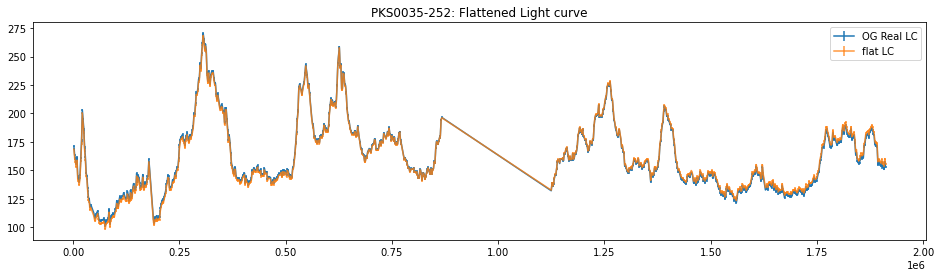

Current run time: 12.663470 s

Rebinning data.




Noise level as determined by fit (offset):  0.25941422358


Estimating noise frequency.



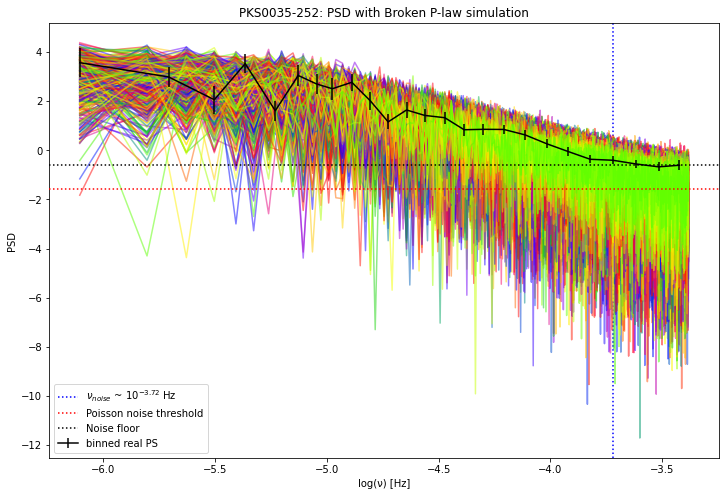

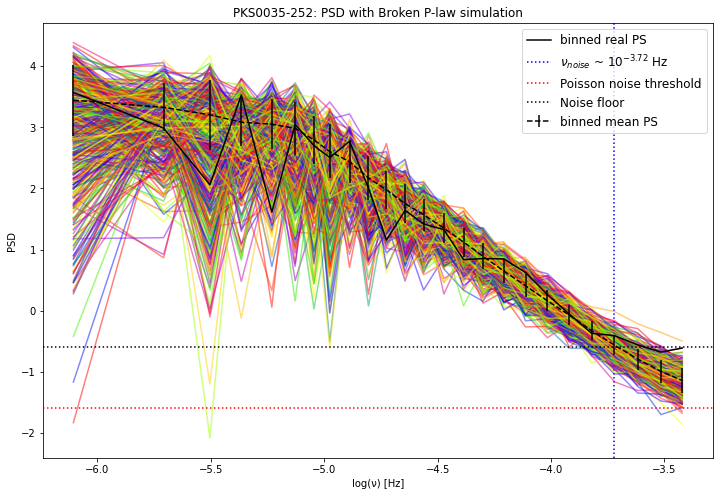

(Χ^2, p_a) = (32.45,0.4940)



Would you like to adjust noise frequency for the mean-subtracted data? [y/n] y


Enter the new noise frequency in logarithmic form (e.g. for 10^-5, just enter -5)


Noise freq. for meansub data (previously 10^-3.720262):  -3.8
Renormalize PSD?  


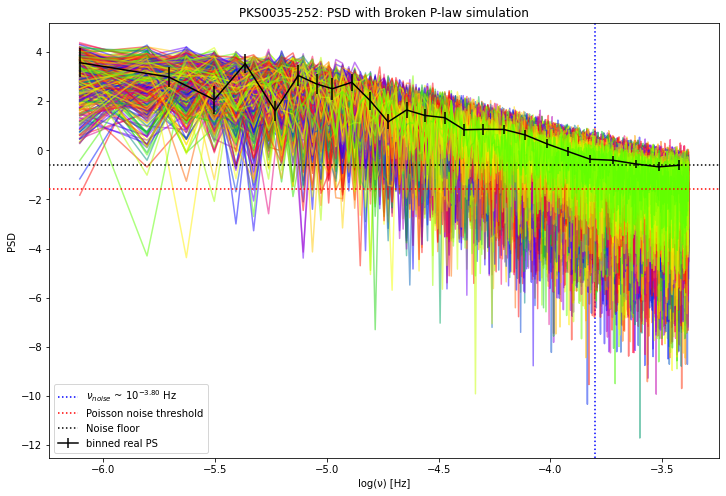

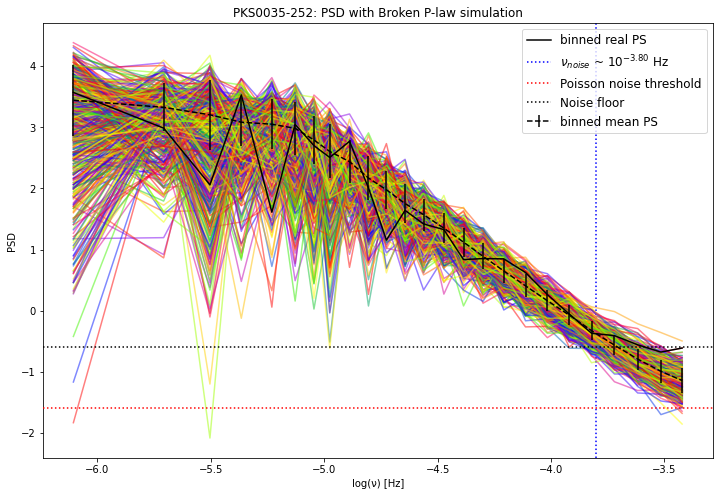

(Χ^2, p_a) = (31.52,0.5040)



Would you like to adjust noise frequency for the mean-subtracted data? [y/n] 


Current run time: 130.229923 s

Fitting data.


Rank: 248/500


Are values satisfactory? (Χ^2, p_a) = (31.52,0.5040)? [y/n]:  y


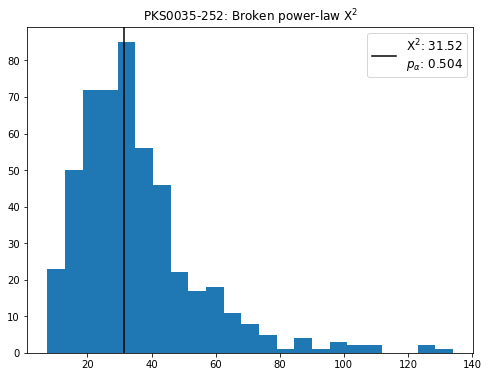

Please input the fit values as derived from the simulation: 


Slope:  2.606250252
Break freq:  4.79269854e-6


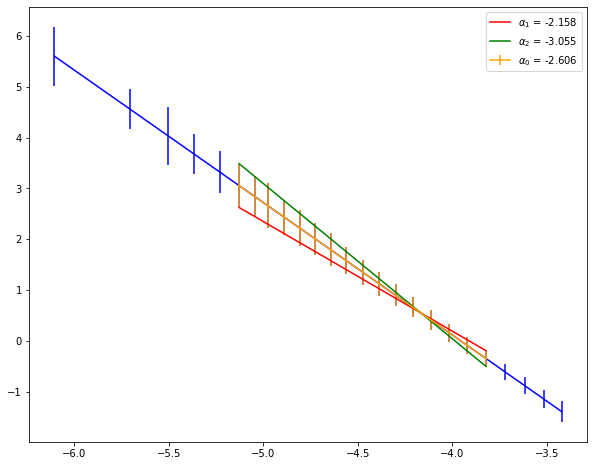

FileNotFoundError: [Errno 2] No such file or directory: '/users/rdingler/AGNstudy/Sim_Results/PKS0035-252/simulated_lightcurves/../0AnalysisFigures/PKS0035-252_full_corr_sim_Powerspec_brknplaw.png'

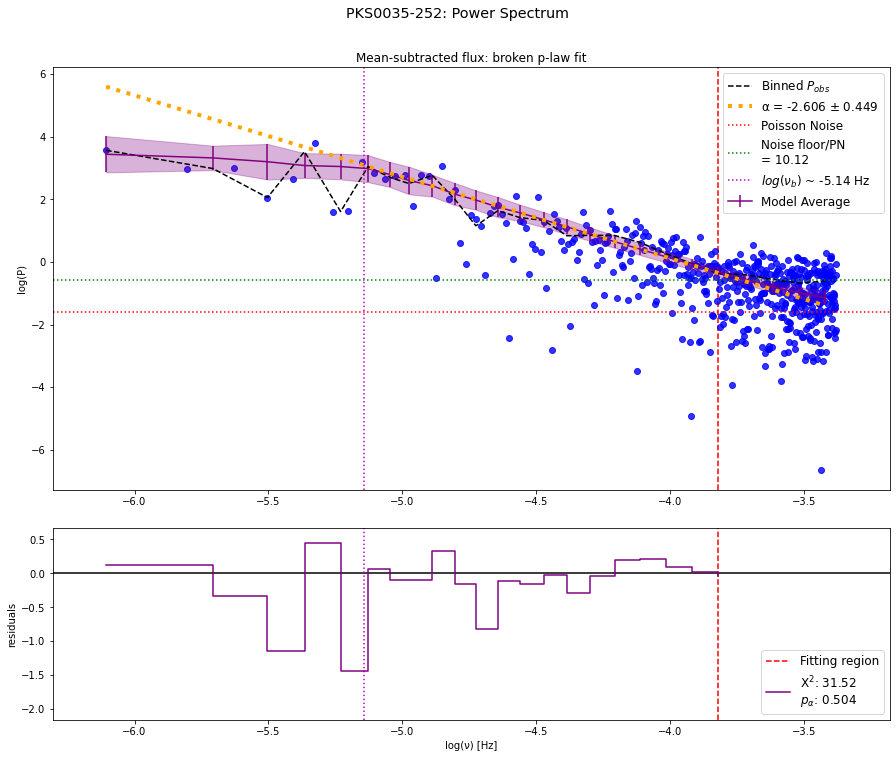

In [17]:
starttime = time.time()


if sectbysect == False:
    if Q == 0:
        print("Starting p-law analysis \n")
        datfile = target+'_long_lightcurve_EmmanSim_plaw.dat'
    if Q == 1:
        print("Starting broken p-law analysis \n")
        datfile = target+'_long_lightcurve_EmmanSim_brknplaw.dat'
    if Q == 2:
        print("Starting p-law with lorentzian analysis \n")
        datfile = target+'_long_lightcurve_EmmanSim_lrntzplaw.dat'
    if Q == 3:
        print("Starting bending p-law analysis \n")
        datfile = target+'_long_lightcurve_EmmanSim_bendplaw.dat'
        
    data = np.loadtxt(rootdir+datfile)
    df = pd.DataFrame(data)
#     print(df)

    full_data, reduced_ps, poisson = correct_data(df, rootdir, target,\
                                                                 num_lcs, z, bkg, gausserr, Q)
    print("Current run time: %f s\n"%(time.time()-starttime))

    binnedps, model_avg, binstd, logstd, noisefreq,\
                                noisefloor = rebinning(rootdir, target, reduced_ps, poisson, Q)

    print("Current run time: %f s\n"%(time.time()-starttime))

    fitfreq, res, chi2 = fit_to_model(rootdir, target, num_lcs,\
                                     binnedps, model_avg, logstd, noisefreq, Q)
    
    plot_Chi2Dist(rootdir, target, chi2, Q)
    FinalAnalysisPlot(reduced_ps, binnedps, model_avg, logstd, poisson, noisefloor, fitfreq, res, chi2, Q)

    
else:
    
    if Q == 0:
        datfile = target+'_long_lightcurve_EmmanSim_plaw_sector_'+group+'.dat'
    if Q == 1:
        datfile = target+'_long_lightcurve_EmmanSim_brknplaw_sector_'+group+'.dat'
    if Q == 2:
        datfile = target+'_long_lightcurve_EmmanSim_lrntzplaw_sector_'+group+'.dat'
    if Q == 3:
        datfile = target+'_long_lightcurve_EmmanSim_bendplaw_sector_'+group+'.dat'

    data = np.loadtxt(rootdir+datfile)
    df = pd.DataFrame(data)

    full_data, reduced_ps, poisson = correct_data(df, rootdir, target,\
                                                                 num_lcs, z, bkg, gausserr, Q, sectbysect, group = group)
    print("Current run time: %f s\n"%(time.time()-starttime))

    binnedps, model_avg, binstd, logstd, noisefreq,\
                            noisefloor = rebinning(rootdir, target, reduced_ps, poisson, Q, sectbysect, group = group)

    print("Current run time: %f s\n"%(time.time()-starttime))

    fitfreq, res, chi2 = fit_to_model(rootdir, target, num_lcs,\
                             binnedps, model_avg, logstd, noisefreq, Q, sectbysect, group = group)

    plot_Chi2Dist(rootdir, target, chi2, Q, sectbysect, group = group)
    FinalAnalysisPlot(reduced_ps, binnedps, model_avg, logstd, poisson, noisefloor, fitfreq, res, chi2, Q, sectbysect, group = group)

print("Full run time: %f s\n"%(time.time()-starttime))

In [18]:
# 0.02563271473703359
# 2.096989083
# 2.68007866739403e-6